In [1]:
"""
Report downstream performance scores for a pretrained model.
"""

import sys, os

env_root = '/N/project/baby_vision_curriculum/pythonenvs/hfenv/lib/python3.10/site-packages/'
sys.path.insert(0, env_root)

os.environ['OPENBLAS_NUM_THREADS'] = '38' #@@@@ to help with the num_workers issue
os.environ['OMP_NUM_THREADS'] = '1'  #10

import numpy as np
import torch, torchvision
from torchvision import transforms as tr
from tqdm import tqdm
from pathlib import Path
# import math
import argparse
import pandas as pd
import warnings
from PIL import Image
import transformers

import torch.distributed as dist
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
import torch.multiprocessing as mp
from ddputils import is_main_process, save_on_master, setup_for_distributed

# torchvision.disable_beta_transforms_warning()
# import torchvision.transforms.v2 as tr #May 9: would require reinstalling th evirtual env.
# we might do it later.

# import torch.nn as nn


# SCRIPT_DIR = os.path.realpath(os.path.dirname(inspect.getfile(inspect.currentframe()))) #os.getcwd() #
# # print('cwd: ',SCRIPT_DIR)
# #os.path.realpath(os.path.dirname(inspect.getfile(inspect.currentframe())))
# util_path = os.path.normpath(os.path.join(SCRIPT_DIR, '..', 'util'))
# sys.path.insert(0, util_path)    


# from train_downstream_VideoMAE import train_classifier_ddp
# from make_toybox_dataset import make_toybox_dataset
from transformers import VideoMAEConfig, VideoMAEModel
from torch.utils.data import Dataset
import av


In [175]:
def _get_transform(image_size):

    mean = [0.5, 0.5, 0.5]#np.mean(mean_all, axis=0) #mean_all[chosen_subj] 
    std = [0.25, 0.25, 0.25] #std_all[chosen_subj] 
    
#     [0.485, 0.456, 0.406]  # IMAGENET_DEFAULT_MEAN
#     [0.229, 0.224, 0.225]  # IMAGENET_DEFAULT_STD

    augs = [tr.Resize(image_size), tr.CenterCrop(image_size), 
            tr.ConvertImageDtype(torch.float32), 
             tr.Normalize(mean,std)]
    return tr.Compose(augs)

def transform_image(image):
#     Used for standard single image datasets such as torchvision.CIFAR10, torchvision.ImageNet
#     if image.shape[0]!=3:
    image_size=224
    num_frames=16
    transform = _get_transform(image_size)
    
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    
    image_tr = transform(image)

    return image_tr.unsqueeze(0).repeat(num_frames,1,1,1)


In [196]:
# val_solution_fp = '/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/LOC_val_solution.csv'

# def proc_val_solution(fp):
#     xdf = pd.read_csv(fp, sep=',')
#     fnames = xdf['ImageId']
#     fnames = fnames.apply(lambda x: x+'.JPEG')

#     synsets = xdf['PredictionString']
#     synsets = synsets.apply(lambda x: x.split(' ')[0])
    
#     labels = 
#     return fnames, synsets

# fnames, synsets = proc_val_solution(val_solution_fp)

# xdf = pd.DataFrame({
#     'filename':fnames,
#     'target':synsets
# })
# xdf.to_csv('val_targets.csv', index=False)

In [249]:
val_path = '/N/project/baby_vision_curriculum/github/baby-vision-curriculum/benchmarks/imagenet/val_targets.csv'
train_path = '/N/project/baby_vision_curriculum/github/baby-vision-curriculum/benchmarks/imagenet/train_targets.csv'
tr_data = pd.read_csv(train_path).sort_values('target')
val_data = pd.read_csv(val_path).sort_values('target')

In [253]:
tr_data.iloc[100:,:]

,filename,target
47332,n01443537_20545.JPEG,n01443537
47331,n01443537_1220.JPEG,n01443537
47330,n01443537_9946.JPEG,n01443537
47325,n01443537_3033.JPEG,n01443537
47328,n01443537_5697.JPEG,n01443537
...,...,...
45227,n15075141_19314.JPEG,n15075141
45226,n15075141_21282.JPEG,n15075141
45225,n15075141_19940.JPEG,n15075141
45235,n15075141_3042.JPEG,n15075141


In [254]:
val_data.iloc[50:,:]

,filename,target
11243,ILSVRC2012_val_00003150.JPEG,n01443537
41871,ILSVRC2012_val_00044095.JPEG,n01443537
33710,ILSVRC2012_val_00010509.JPEG,n01443537
3573,ILSVRC2012_val_00031138.JPEG,n01443537
24580,ILSVRC2012_val_00011914.JPEG,n01443537
...,...,...
46583,ILSVRC2012_val_00006055.JPEG,n15075141
32563,ILSVRC2012_val_00042270.JPEG,n15075141
42209,ILSVRC2012_val_00039432.JPEG,n15075141
26136,ILSVRC2012_val_00038640.JPEG,n15075141


In [316]:
def get_fnames_labels(csv_file):
    data = pd.read_csv(csv_file).sort_values('target')
    print(data['filename'])
    le = preprocessing.LabelEncoder()
    fnames = data['filename']
    labels = le.fit_transform(data['target'])
    synsets = data['target']
    return fnames, labels, synsets

In [313]:
# data = get_fnames_labels(train_path)

In [317]:
# data['filename']

In [320]:
tr_fnames, tr_labels, tr_synsets = get_fnames_labels(train_path)
va_fnames, val_labels, val_synsets = get_fnames_labels(val_path)

74899     n01440764_4565.JPEG
74873     n01440764_2118.JPEG
74872    n01440764_21052.JPEG
74871    n01440764_13316.JPEG
74870     n01440764_5908.JPEG
                 ...         
45227    n15075141_19314.JPEG
45226    n15075141_21282.JPEG
45225    n15075141_19940.JPEG
45235     n15075141_3042.JPEG
45298    n15075141_26621.JPEG
Name: filename, Length: 100000, dtype: object
23798    ILSVRC2012_val_00025129.JPEG
21319    ILSVRC2012_val_00023559.JPEG
17008    ILSVRC2012_val_00024327.JPEG
43391    ILSVRC2012_val_00037834.JPEG
3228     ILSVRC2012_val_00030740.JPEG
                     ...             
46583    ILSVRC2012_val_00006055.JPEG
32563    ILSVRC2012_val_00042270.JPEG
42209    ILSVRC2012_val_00039432.JPEG
26136    ILSVRC2012_val_00038640.JPEG
41093    ILSVRC2012_val_00027432.JPEG
Name: filename, Length: 50000, dtype: object


In [321]:
tr_fnames

74899     n01440764_4565.JPEG
74873     n01440764_2118.JPEG
74872    n01440764_21052.JPEG
74871    n01440764_13316.JPEG
74870     n01440764_5908.JPEG
                 ...         
45227    n15075141_19314.JPEG
45226    n15075141_21282.JPEG
45225    n15075141_19940.JPEG
45235     n15075141_3042.JPEG
45298    n15075141_26621.JPEG
Name: filename, Length: 100000, dtype: object

In [307]:
data = pd.read_csv(train_path).sort_values('target')
data

,filename,target
74899,n01440764_4565.JPEG,n01440764
74873,n01440764_2118.JPEG,n01440764
74872,n01440764_21052.JPEG,n01440764
74871,n01440764_13316.JPEG,n01440764
74870,n01440764_5908.JPEG,n01440764
...,...,...
45227,n15075141_19314.JPEG,n15075141
45226,n15075141_21282.JPEG,n15075141
45225,n15075141_19940.JPEG,n15075141
45235,n15075141_3042.JPEG,n15075141


In [297]:
tr_labels

array([  0,   0,   0, ..., 999, 999, 999])

In [310]:
tr_synsets

74899    n01440764
74873    n01440764
74872    n01440764
74871    n01440764
74870    n01440764
           ...    
45227    n15075141
45226    n15075141
45225    n15075141
45235    n15075141
45298    n15075141
Name: target, Length: 100000, dtype: object

In [300]:
print(tr_synsets[0], tr_labels[0])

n02112137 0


In [290]:
import PIL

In [325]:
tr_fnames.iloc[0]

'n01440764_4565.JPEG'

In [302]:
tr_synsets[idx]

'n02112137'

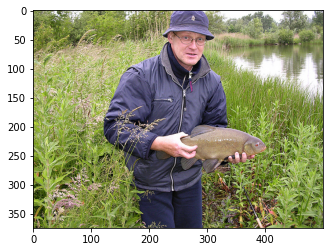

In [326]:
train_root='/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/train/'
idx = 0
img_fp = f"{train_root}{tr_synsets.iloc[idx]}/{tr_fnames.iloc[idx]}"
plt.imshow(PIL.Image.open(img_fp))

In [328]:
from sklearn import preprocessing

def get_fnames_synsets(csv_file):
    data = pd.read_csv(csv_file).sort_values('target')
#     le = preprocessing.LabelEncoder()
    fnames = data['filename']
#     labels = le.fit_transform(data['target'])
    synsets = data['target']
    return fnames.tolist(), synsets.tolist()

def get_synset_encoder(csv_fp):
    data = pd.read_csv(csv_fp).sort_values('target')
    synsets = data['target']
    le = preprocessing.LabelEncoder()
    le = le.fit(synsets)
    return le

# class ImageNetDataset(Dataset):
#     def __init__(self, csv_fp, root_dir, transform=None):
#         self.fnames, self.labels, self.synsets = get_fnames_labels(csv_fp)
#         # synsets come sorted
# #         self.synset_encoder = get_synset_encoder(self.train_synsets)
# #         self.train_labels = self.synset_encoder.transform(self.synsets)
# #         self.data = pd.read_csv(csv_file).sort_values('target')
#         self.root_dir = root_dir
#         self.transform = transform
        
#     def __len__(self):
#         return len(self.fnames)
    
    
        # synsets come sorted
#         self.synset_encoder = get_synset_encoder(self.synsets)
#         self.labels = self.synset_encoder.transform(self.synsets)
#         self.data = pd.read_csv(csv_file).sort_values('target')

# class TrainDataset(Dataset):
#     def __init__(self, csv_file, root_dir, label_encoder, transform=None):
#         self.fnames, self.labels, self.synsets = get_fnames_labels(csv_file)
#         self.root_dir = root_dir
#         self.transform = transform

#     def __len__(self):
#         return len(self.fnames)

#     def __getitem__(self, idx):
#         img_fp = f"{self.root_dir}{self.synsets[idx]}/{self.fnames[idx]}"
# #         img_name = f"{self.root_dir}/{self.data.iloc[idx, 1]}/{self.data.iloc[idx, 0]}"
#         image = torchvision.io.read_image(img_fp)
#         label = self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
# #         print(image.shape)

#         return image, label
class TrainDataset(Dataset):
    def __init__(self, csv_file, root_dir, label_encoder, transform=None):
        self.fnames, self.synsets = get_fnames_synsets(csv_file)
        self.labels = label_encoder.transform(self.synsets)
        print(type(self.labels))
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_fp = f"{self.root_dir}{self.synsets[idx]}/{self.fnames[idx]}"
#         img_name = f"{self.root_dir}/{self.data.iloc[idx, 1]}/{self.data.iloc[idx, 0]}"
        image = torchvision.io.read_image(img_fp)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
#         print(image.shape)

        return image, label

class ValDataset(Dataset):
    def __init__(self, csv_file, root_dir, label_encoder, transform=None):
        self.fnames, self.synsets = get_fnames_synsets(csv_file)
        self.labels = label_encoder.transform(self.synsets)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.fnames)

    def __getitem__(self, idx):
        img_fp = f"{self.root_dir}{self.fnames[idx]}"
#         img_name = f"{self.root_dir}/{self.data.iloc[idx, 1]}/{self.data.iloc[idx, 0]}"
        image = torchvision.io.read_image(img_fp)
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
#         print(image.shape)

        return image, label

#         img_name = f"{self.root_dir}{self.data.iloc[idx, 0]}.JPEG"
#         image = Image.open(img_name)
#         label = self.data.iloc[idx, 1].split(' ')[0]
#         if self.transform:
#             image = self.transform(image)

#         return image, torch.tensor([label])

In [329]:
# def transform_image_cifar10_or_imagenet(image):
# #     Used for standard single image datasets such as torchvision.CIFAR10, torchvision.ImageNet
#     image_size=224
#     num_frames=16
#     mean = [0.5, 0.5, 0.5]#np.mean(mean_all, axis=0) #mean_all[chosen_subj] 
#     std = [0.25, 0.25, 0.25] #std_all[chosen_subj] 
    
# #     [0.485, 0.456, 0.406]  # IMAGENET_DEFAULT_MEAN
# #     [0.229, 0.224, 0.225]  # IMAGENET_DEFAULT_STD

#     augs = [tr.ToTensor(),
#             tr.Resize(image_size), tr.CenterCrop(image_size),
#             tr.ConvertImageDtype(torch.float32), 
#              tr.Normalize(mean,std)]
#     transform = tr.Compose(augs)
#     transformed_image = transform(image)

#     # If the image is grayscale, convert it to RGB
#     if transformed_image.shape[0] == 1:
#         transformed_image = transformed_image.repeat(3, 1, 1)

#     # Repeat the transformed image for the desired number of frames
#     transformed_image = transformed_image.unsqueeze(0).repeat(num_frames, 1, 1, 1)

#     return transformed_image
    
#     return transform(image).unsqueeze(0).repeat(num_frames,1,1,1)

def make_imagenet_dataset(args):
    imagenet_root='/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/ILSVRC/Data/CLS-LOC/'
#     val_path = '/N/project/baby_vision_curriculum/benchmarks/mainstream/imagenet/LOC_val_solution.csv'
    val_path = '/N/project/baby_vision_curriculum/github/baby-vision-curriculum/benchmarks/imagenet/val_targets.csv'
    train_path = '/N/project/baby_vision_curriculum/github/baby-vision-curriculum/benchmarks/imagenet/train_targets.csv'
    transform = transform_image
    label_encoder = get_synset_encoder(train_path)
    train_dataset = TrainDataset(train_path, f"{imagenet_root}train/",
                                                            label_encoder, transform=transform)
    val_dataset =  ValDataset(val_path, f"{imagenet_root}val/", 
                              label_encoder, transform=transform)
    image_datasets = {'train': train_dataset , 'val':val_dataset}
    num_classes = 1000 
        
    return image_datasets, num_classes


In [330]:
def get_config(image_size, args, num_labels=2):
    arch_kw = args.architecture
    if arch_kw=='small2':
        hidden_size = 768
        intermediate_size = 4*768
        num_attention_heads = 6
        num_hidden_layers = 6
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size, num_labels=num_labels)
    
    elif arch_kw=='base': #default
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=768, num_hidden_layers=12, num_attention_heads=12,
                                             intermediate_size=3072, num_labels=num_labels)
    elif arch_kw=='small1':
        hidden_size = 384
        intermediate_size = 4*384
        num_attention_heads = 6
        num_hidden_layers = 12
        
        config = transformers.VideoMAEConfig(image_size=image_size, patch_size=16, num_channels=3,
                                             num_frames=16, tubelet_size=2, 
                                             hidden_size=hidden_size, num_hidden_layers=num_hidden_layers, num_attention_heads=num_attention_heads,
                                             intermediate_size=intermediate_size, num_labels=num_labels)
        
    else:
        raise ValueError
    return config


def init_model_from_checkpoint(model, checkpoint_path):
    # caution: model class
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def adapt_videomae(source_model, target_model):
    # load the embeddings
    target_model.videomae.embeddings.load_state_dict(
        source_model.videomae.embeddings.state_dict())
#     load the encoder
    target_model.videomae.encoder.load_state_dict(
        source_model.videomae.encoder.state_dict())
    return target_model

def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
        for param in model.classifier.parameters():
            param.requires_grad = True
            
def get_model(image_size, num_labels, feature_extracting, args):
    config_source = get_config(image_size, args)
    model_source = transformers.VideoMAEForPreTraining(config_source)
    
    if args.init_checkpoint_path!='na':
        print('args.init_checkpoint_path:',args.init_checkpoint_path)
        # initialize the model using the checkpoint
        model_source = init_model_from_checkpoint(model_source, args.init_checkpoint_path)
  
    config_target = get_config(image_size, args, num_labels=num_labels)
    model_target = transformers.VideoMAEForVideoClassification(config=config_target)
    model_target = adapt_videomae(model_source, model_target)
    if not torch.all(
        model_target.videomae.embeddings.patch_embeddings.projection.weight==model_source.videomae.embeddings.patch_embeddings.projection.weight):
        warnings.warn('Model not successfully initialized')
    
    if feature_extracting:
        set_parameter_requires_grad(model_target, feature_extracting)
    
    return model_target

        
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']
    
def get_optimizer(model, feature_extract, args):
    params_to_update = model.parameters()
    print("Params to learn:")
    if feature_extract:
        params_to_update = []
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                params_to_update.append(param)
                print("\t",name)
    else:
        for name,param in model.named_parameters():
            if param.requires_grad == True:
                print("\t",name)

#     if feature_extract:
    lr = args.lr#1e-3
    weight_decay =args.wd#5e-5
    optimizer_ft = torch.optim.Adam(params_to_update, lr=lr, weight_decay=weight_decay)
    #     optimizer_ft = torch.optim.SGD([{'params': params_to_update, 
    #                               'initial_lr':lr}], 
    #                             lr=lr, momentum=0.9)
#     else:
#         lr=1e-4
#         optimizer_ft = torch.optim.Adam(params_to_update, lr=lr)
        
    return optimizer_ft

def make_dataset(args):
    task = args.task
    if task=='ucf101':
        return make_ucf101dataset(args)
#     seq_len = kwargs['seq_len']
#     image_size = kwargs['image_size']
    elif task=='cifar10':
        return make_cifar10dataset(args)
    elif task=='imagenet':
        return make_imagenet_dataset(args)
    else:
        raise NotImplementedError()

In [331]:
class Args:
    def __init__(self, **kwargs):
        for key, value in kwargs.items():
            setattr(self, key, value)

In [332]:
architecture='base'
init_checkpoint_path='na'
savedir=None
seed=1
batch_size = 16
finetune='n'
frame_rate=30
lr=1e-3
wd=5e-5
num_workers=6
task='imagenet'
n_epoch=1
args = Args(task=task,
            architecture=architecture,
            init_checkpoint_path=init_checkpoint_path,
            savedir=savedir,
            seed=seed,
            frame_rate=frame_rate,
            num_workers=num_workers,
            finetune=finetune,
            batch_size=batch_size,
           lr=lr, wd=wd,
           n_epoch=n_epoch)

In [333]:
datasets, num_classes = make_dataset(args)

<class 'numpy.ndarray'>


In [338]:
inp, label = datasets['val'][100]
print(label)

2


In [340]:
inp, label = datasets['train'][200]
print(label)

2


In [267]:
import matplotlib.pyplot as plt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


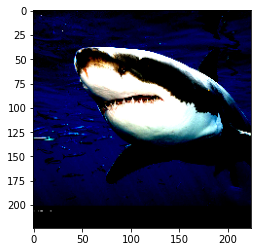

In [339]:
inp2 = inp.permute(0, 2, 3, 1)
plt.imshow(inp2[2,...])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


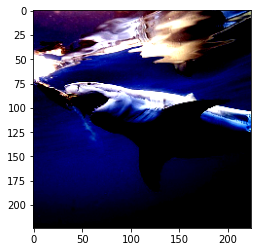

In [341]:
inp2 = inp.permute(0, 2, 3, 1)
plt.imshow(inp2[2,...])

In [23]:
feature_extract = True
image_size = 224
feature_extract = (args.finetune=='n')
xmodel = get_model(image_size, num_classes, feature_extract, args)
world_size = 4
rank = 0
xmodel = xmodel.to(rank)

In [120]:
optimizer = get_optimizer(xmodel, feature_extract, args) 


Params to learn:
	 classifier.weight
	 classifier.bias


In [342]:


sampler_shuffle = True #for the distributed dampler
num_epochs = args.n_epoch
batch_size = args.batch_size# 128
pin_memory = True
num_workers = args.num_workers #number_of_cpu-1#32

if args.task=='ucf101':
    collate_fn = ucf_collate
else:
    collate_fn = None
# print('n cpu: ', number_of_cpu, ' n workers: ', num_workers)

samplers_dict = {x: DistributedSampler(datasets[x], num_replicas=world_size, 
                                       rank=rank, shuffle=sampler_shuffle, 
                                       seed=seed)
                 for x in ['train', 'val']}
print("Collate function", collate_fn)
dataloaders = {x: torch.utils.data.DataLoader(
    datasets[x], batch_size=batch_size, pin_memory=pin_memory, collate_fn=collate_fn,
    num_workers=num_workers, shuffle=False, sampler=samplers_dict[x], drop_last=True)
                    for x in ['train', 'val']}

Collate function None


In [343]:
print('len dset, len dloader: ', len(datasets['train']), len(dataloaders['train']))

len dset, len dloader:  100000 1562


In [344]:
# phase = 'train'
# for batch in tqdm(dataloaders[phase]):
#     break

In [347]:
verbose = True
train_acc_history = []
val_acc_history = []

# best_model_wts = deepcopy(model.state_dict())
best_acc = 0.0

for i_ep in range(num_epochs):
    if verbose:
        print('Epoch {}/{}'.format(i_ep, num_epochs - 1))
        print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        print("Here")
        dataloaders[phase].sampler.set_epoch(i_ep)
        print("I'm here")
        if phase == 'train':
            xmodel.train()  # Set model to training mode
        else:
            xmodel.eval()   # Set model to evaluate mode

        running_loss = torch.tensor([0.0], device=rank)
        running_corrects = torch.tensor([0.0], device=rank)

        i_iter, print_period=0, 100  
#         i_break, print_period = 200,5 #@@@ debug
        # Iterate over data.
        print("phase", phase)
#         dataiter = iter(dataloaders[phase])
#         images, labels = next(dataiter)
#         print(images.shape)
        for batch in tqdm(dataloaders[phase]):
            # zero the parameter gradients
            optimizer.zero_grad()

#                 loss, logits = get_loss(task, batch, phase, rank, args)

            # implement get_loss for different datasets and for videomaeclassifier
            inputs, labels = batch #get_inp_label(args.task, batch)
#             print("Here", inputs.shape)
            inputs = inputs.to(rank)
            labels = labels.to(rank)
            outputs = xmodel(pixel_values=inputs, labels=labels)

            logits = outputs.logits
            loss = outputs.loss

            _, preds = torch.max(logits, 1)

            # backward + optimize only if in training phase
            if phase == 'train':
                loss.backward()
                optimizer.step()

            # statistics
            running_loss += loss.item() * inputs.size(0)
#                 print(rank, 'labels shape, device: ', labels.shape, labels.data.device)
#                 print(rank, 'preds shape, device: ', preds.shape, preds.device)
            running_corrects += torch.sum(preds == labels.data)

            i_iter+=1
            if (i_iter%print_period)==0:
                print('loss:',loss.item())
                memory_allocated = torch.cuda.memory_allocated() / 1024**2
                print(f'GPU memory allocated: {memory_allocated:.2f} MB')
                
#             if i_iter==i_break:
#                 break #@@@@ debug

Epoch 0/0
----------
Here
I'm here
phase train


  0%|▏                                         | 5/1562 [00:02<13:20,  1.95it/s]

loss: 4.6384100914001465
GPU memory allocated: 637.43 MB


  1%|▎                                        | 10/1562 [00:05<12:24,  2.08it/s]

loss: 4.916719436645508
GPU memory allocated: 637.43 MB


  1%|▍                                        | 15/1562 [00:07<12:15,  2.10it/s]

loss: 5.052672386169434
GPU memory allocated: 637.43 MB


  1%|▌                                        | 20/1562 [00:09<12:11,  2.11it/s]

loss: 4.950407028198242
GPU memory allocated: 637.43 MB


  2%|▋                                        | 25/1562 [00:12<12:08,  2.11it/s]

loss: 9.877914428710938
GPU memory allocated: 637.43 MB


  2%|▊                                        | 30/1562 [00:14<12:07,  2.11it/s]

loss: 9.713483810424805
GPU memory allocated: 637.43 MB


  2%|▉                                        | 35/1562 [00:17<12:06,  2.10it/s]

loss: 10.025362014770508
GPU memory allocated: 637.43 MB


  3%|█                                        | 40/1562 [00:19<12:01,  2.11it/s]

loss: 10.128983497619629
GPU memory allocated: 637.43 MB


  3%|█▏                                       | 45/1562 [00:21<11:59,  2.11it/s]

loss: 9.211750984191895
GPU memory allocated: 637.43 MB


  3%|█▎                                       | 50/1562 [00:24<11:57,  2.11it/s]

loss: 9.288354873657227
GPU memory allocated: 637.43 MB


  4%|█▍                                       | 55/1562 [00:26<11:55,  2.11it/s]

loss: 9.176788330078125
GPU memory allocated: 637.43 MB


  4%|█▌                                       | 60/1562 [00:28<11:52,  2.11it/s]

loss: 8.75922966003418
GPU memory allocated: 637.43 MB


  4%|█▋                                       | 65/1562 [00:31<11:50,  2.11it/s]

loss: 8.580585479736328
GPU memory allocated: 637.43 MB


  4%|█▊                                       | 70/1562 [00:33<11:47,  2.11it/s]

loss: 8.650453567504883
GPU memory allocated: 637.43 MB


  5%|█▉                                       | 75/1562 [00:36<11:45,  2.11it/s]

loss: 7.764535903930664
GPU memory allocated: 637.43 MB


  5%|██                                       | 80/1562 [00:38<11:43,  2.11it/s]

loss: 9.042963027954102
GPU memory allocated: 637.43 MB


  5%|██▏                                      | 85/1562 [00:40<11:40,  2.11it/s]

loss: 8.960711479187012
GPU memory allocated: 637.43 MB


  6%|██▎                                      | 90/1562 [00:43<11:39,  2.10it/s]

loss: 8.787643432617188
GPU memory allocated: 637.43 MB


  6%|██▍                                      | 95/1562 [00:45<11:35,  2.11it/s]

loss: 8.042308807373047
GPU memory allocated: 637.43 MB


  6%|██▌                                     | 100/1562 [00:47<11:33,  2.11it/s]

loss: 7.9175615310668945
GPU memory allocated: 637.43 MB


  7%|██▋                                     | 105/1562 [00:50<11:31,  2.11it/s]

loss: 9.258269309997559
GPU memory allocated: 637.43 MB


  7%|██▊                                     | 110/1562 [00:52<11:28,  2.11it/s]

loss: 7.630119323730469
GPU memory allocated: 637.43 MB


  7%|██▉                                     | 115/1562 [00:55<11:26,  2.11it/s]

loss: 8.955482482910156
GPU memory allocated: 637.43 MB


  8%|███                                     | 120/1562 [00:57<11:26,  2.10it/s]

loss: 8.287837028503418
GPU memory allocated: 637.43 MB


  8%|███▏                                    | 125/1562 [00:59<11:21,  2.11it/s]

loss: 7.183791160583496
GPU memory allocated: 637.43 MB


  8%|███▎                                    | 130/1562 [01:02<11:18,  2.11it/s]

loss: 9.004569053649902
GPU memory allocated: 637.43 MB


  9%|███▍                                    | 135/1562 [01:04<11:16,  2.11it/s]

loss: 8.095295906066895
GPU memory allocated: 637.43 MB


  9%|███▌                                    | 140/1562 [01:06<11:14,  2.11it/s]

loss: 7.811026573181152
GPU memory allocated: 637.43 MB


  9%|███▋                                    | 145/1562 [01:09<11:11,  2.11it/s]

loss: 9.004969596862793
GPU memory allocated: 637.43 MB


 10%|███▊                                    | 150/1562 [01:11<11:09,  2.11it/s]

loss: 9.417045593261719
GPU memory allocated: 637.43 MB


 10%|███▉                                    | 155/1562 [01:13<11:06,  2.11it/s]

loss: 8.70196533203125
GPU memory allocated: 637.43 MB


 10%|████                                    | 160/1562 [01:16<11:04,  2.11it/s]

loss: 7.91119909286499
GPU memory allocated: 637.43 MB


 11%|████▏                                   | 165/1562 [01:18<11:05,  2.10it/s]

loss: 7.85260009765625
GPU memory allocated: 637.43 MB


 11%|████▎                                   | 170/1562 [01:21<11:03,  2.10it/s]

loss: 7.773950099945068
GPU memory allocated: 637.43 MB


 11%|████▍                                   | 175/1562 [01:23<10:58,  2.11it/s]

loss: 8.11253833770752
GPU memory allocated: 637.43 MB


 12%|████▌                                   | 180/1562 [01:25<10:57,  2.10it/s]

loss: 7.759117603302002
GPU memory allocated: 637.43 MB


 12%|████▋                                   | 185/1562 [01:28<10:52,  2.11it/s]

loss: 7.716614246368408
GPU memory allocated: 637.43 MB


 12%|████▊                                   | 190/1562 [01:30<10:50,  2.11it/s]

loss: 8.494922637939453
GPU memory allocated: 637.43 MB


 12%|████▉                                   | 195/1562 [01:32<10:52,  2.09it/s]

loss: 8.225820541381836
GPU memory allocated: 637.43 MB


 13%|█████                                   | 199/1562 [01:34<10:47,  2.11it/s]

loss: 8.11757755279541
GPU memory allocated: 637.43 MB


 13%|█████                                   | 199/1562 [01:36<11:01,  2.06it/s]


Here
I'm here
phase val


  1%|▎                                          | 5/781 [00:02<06:38,  1.95it/s]

loss: 8.123064041137695
GPU memory allocated: 637.54 MB


  1%|▌                                         | 10/781 [00:05<06:09,  2.09it/s]

loss: 8.602823257446289
GPU memory allocated: 637.54 MB


  2%|▊                                         | 15/781 [00:07<06:03,  2.11it/s]

loss: 7.3411760330200195
GPU memory allocated: 637.54 MB


  3%|█                                         | 20/781 [00:09<06:00,  2.11it/s]

loss: 8.067548751831055
GPU memory allocated: 637.54 MB


  3%|█▎                                        | 25/781 [00:12<05:57,  2.11it/s]

loss: 8.286067962646484
GPU memory allocated: 637.54 MB


  4%|█▌                                        | 30/781 [00:14<05:55,  2.11it/s]

loss: 7.398810386657715
GPU memory allocated: 637.54 MB


  4%|█▉                                        | 35/781 [00:17<05:53,  2.11it/s]

loss: 7.6164326667785645
GPU memory allocated: 637.54 MB


  5%|██▏                                       | 40/781 [00:19<05:50,  2.11it/s]

loss: 7.825995922088623
GPU memory allocated: 637.54 MB


  6%|██▍                                       | 45/781 [00:21<05:48,  2.11it/s]

loss: 8.298734664916992
GPU memory allocated: 637.54 MB


  6%|██▋                                       | 50/781 [00:24<05:46,  2.11it/s]

loss: 7.724386692047119
GPU memory allocated: 637.54 MB


  7%|██▉                                       | 55/781 [00:26<05:46,  2.10it/s]

loss: 7.873117446899414
GPU memory allocated: 637.54 MB


  8%|███▏                                      | 60/781 [00:28<05:41,  2.11it/s]

loss: 8.243892669677734
GPU memory allocated: 637.54 MB


  8%|███▍                                      | 65/781 [00:31<05:40,  2.11it/s]

loss: 8.154068946838379
GPU memory allocated: 637.54 MB


  9%|███▊                                      | 70/781 [00:33<05:37,  2.11it/s]

loss: 7.5986647605896
GPU memory allocated: 637.54 MB


 10%|████                                      | 75/781 [00:35<05:34,  2.11it/s]

loss: 7.971997261047363
GPU memory allocated: 637.54 MB


 10%|████▎                                     | 80/781 [00:38<05:31,  2.11it/s]

loss: 7.1491289138793945
GPU memory allocated: 637.54 MB


 11%|████▌                                     | 85/781 [00:40<05:29,  2.11it/s]

loss: 8.110217094421387
GPU memory allocated: 637.54 MB


 12%|████▊                                     | 90/781 [00:43<05:27,  2.11it/s]

loss: 7.714844703674316
GPU memory allocated: 637.54 MB


 12%|█████                                     | 95/781 [00:45<05:24,  2.11it/s]

loss: 7.568660259246826
GPU memory allocated: 637.54 MB


 13%|█████▏                                   | 100/781 [00:47<05:22,  2.11it/s]

loss: 7.875662326812744
GPU memory allocated: 637.54 MB


 13%|█████▌                                   | 105/781 [00:50<05:20,  2.11it/s]

loss: 8.437402725219727
GPU memory allocated: 637.54 MB


 14%|█████▊                                   | 110/781 [00:52<05:19,  2.10it/s]

loss: 8.57778263092041
GPU memory allocated: 637.54 MB


 15%|██████                                   | 115/781 [00:54<05:15,  2.11it/s]

loss: 8.16665267944336
GPU memory allocated: 637.54 MB


 15%|██████▎                                  | 120/781 [00:57<05:13,  2.11it/s]

loss: 7.941267967224121
GPU memory allocated: 637.54 MB


 16%|██████▌                                  | 125/781 [00:59<05:10,  2.11it/s]

loss: 8.017154693603516
GPU memory allocated: 637.54 MB


 17%|██████▊                                  | 130/781 [01:02<05:08,  2.11it/s]

loss: 8.307939529418945
GPU memory allocated: 637.54 MB


 17%|███████                                  | 135/781 [01:04<05:05,  2.11it/s]

loss: 8.221442222595215
GPU memory allocated: 637.54 MB


 18%|███████▎                                 | 140/781 [01:06<05:03,  2.11it/s]

loss: 7.638627052307129
GPU memory allocated: 637.54 MB


 19%|███████▌                                 | 145/781 [01:09<05:01,  2.11it/s]

loss: 7.74656343460083
GPU memory allocated: 637.54 MB


 19%|███████▊                                 | 150/781 [01:11<04:58,  2.11it/s]

loss: 7.600796222686768
GPU memory allocated: 637.54 MB


 20%|████████▏                                | 155/781 [01:13<04:56,  2.11it/s]

loss: 8.405119895935059
GPU memory allocated: 637.54 MB


 20%|████████▍                                | 160/781 [01:16<04:54,  2.11it/s]

loss: 7.648085117340088
GPU memory allocated: 637.54 MB


 21%|████████▋                                | 165/781 [01:18<04:51,  2.11it/s]

loss: 7.184080123901367
GPU memory allocated: 637.54 MB


 22%|████████▉                                | 170/781 [01:20<04:49,  2.11it/s]

loss: 8.037199020385742
GPU memory allocated: 637.54 MB


 22%|█████████▏                               | 175/781 [01:23<04:46,  2.11it/s]

loss: 8.02087116241455
GPU memory allocated: 637.54 MB


 23%|█████████▍                               | 180/781 [01:25<04:45,  2.10it/s]

loss: 7.1826491355896
GPU memory allocated: 637.54 MB


 24%|█████████▋                               | 185/781 [01:28<04:42,  2.11it/s]

loss: 7.746597766876221
GPU memory allocated: 637.54 MB


 24%|█████████▉                               | 190/781 [01:30<04:39,  2.11it/s]

loss: 8.070891380310059
GPU memory allocated: 637.54 MB


 25%|██████████▏                              | 195/781 [01:32<04:37,  2.11it/s]

loss: 7.5897979736328125
GPU memory allocated: 637.54 MB


 25%|██████████▍                              | 199/781 [01:34<04:35,  2.11it/s]

loss: 8.364740371704102
GPU memory allocated: 637.54 MB


 25%|██████████▍                              | 199/781 [01:35<04:40,  2.07it/s]


In [ ]:
labels